In [1]:
import torch
from torchvision import transforms, datasets, models
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
device = "gpu" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cpu'

In [4]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [5]:
data_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
test_data = datasets.ImageFolder(test_dir, transform=data_transforms)

print("Train data : ", len(train_data))
print("Test data : ", len(test_data))

Train data :  3130
Test data :  540


In [6]:
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [7]:
data_iter = iter(train_loader)

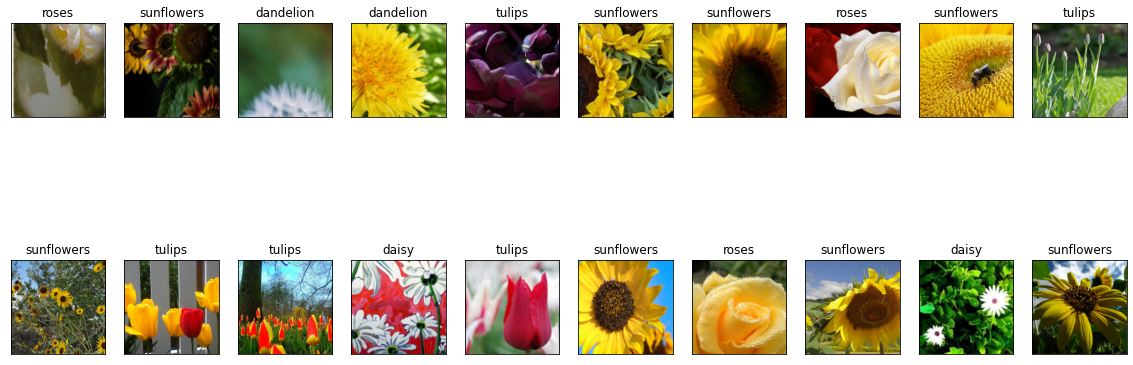

In [8]:
images , labels = data_iter.next()
images = images.numpy()
plt.figure(figsize=(20,8))
for idx in range(20):
    ax = plt.subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(classes[labels[idx]])

In [13]:
vgg16 = models.vgg16(pretrained=True)
total_params = sum([p.numel() for p in vgg16.parameters()])
learnable_params = sum([p.numel() for p in vgg16.parameters() if p.requires_grad])
print(f"Total number of parameters : {total_params},\nTotal number of learning parameters : {learnable_params}")

Total number of parameters : 138357544,
Total number of learning parameters : 138357544


In [14]:
for param in vgg16.parameters():
    param.requires_grad = False

In [15]:
n_inputs = vgg16.classifier[6].in_features
n_inputs

4096

In [16]:
last_layer = nn.Linear(n_inputs, len(classes))
vgg16.classifier[6] = last_layer

if device == 'gpu':
    vgg16.cuda()

vgg16.classifier[6]

Linear(in_features=4096, out_features=5, bias=True)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [14]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [18]:
n_epochs = 2

for epoch in range(n_epochs):
    train_loss = 0.
    for batch_idx, (images, labels) in enumerate(train_loader):
        if device == 'gpu':
            images.to(device)
            labels.to(device)
        optimizer.zero_grad()
        output = vgg16(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_idx + 1, train_loss / 20))
            train_loss = 0.0

C:\Users\prabh\anaconda3\envs\boston_house_prices_prediction\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0, Batch 20 loss: 1.6240228533744812
Epoch 0, Batch 40 loss: 1.4432014882564546
Epoch 0, Batch 60 loss: 1.2710350215435029
Epoch 0, Batch 80 loss: 1.1571915775537491
Epoch 0, Batch 100 loss: 1.1208462476730348
Epoch 0, Batch 120 loss: 1.0189124971628190
Epoch 0, Batch 140 loss: 1.0061711609363555
Epoch 1, Batch 20 loss: 0.9371741771697998
Epoch 1, Batch 40 loss: 0.9421172618865967
Epoch 1, Batch 60 loss: 0.8998075902462006
Epoch 1, Batch 80 loss: 0.8851376920938492
Epoch 1, Batch 100 loss: 0.8517345011234283
Epoch 1, Batch 120 loss: 0.8303693503141403
Epoch 1, Batch 140 loss: 0.8733888149261475


In [19]:
vgg16.eval()

class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

test_loss = 0.
for images, labels in test_loader:
    if device == 'gpu':
        images = images.cuda()
        labels = labels.cuda()
    output = vgg16(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device != 'gpu' else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        # calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.783461

Test Accuracy of daisy: 75% (69/92)
Test Accuracy of dandelion: 89% (118/132)
Test Accuracy of roses: 63% (58/91)
Test Accuracy of sunflowers: 74% (75/101)
Test Accuracy of tulips: 78% (97/124)

Test Accuracy (Overall): 77% (417/540)


<ipython-input-20-086dcf1f3d26>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


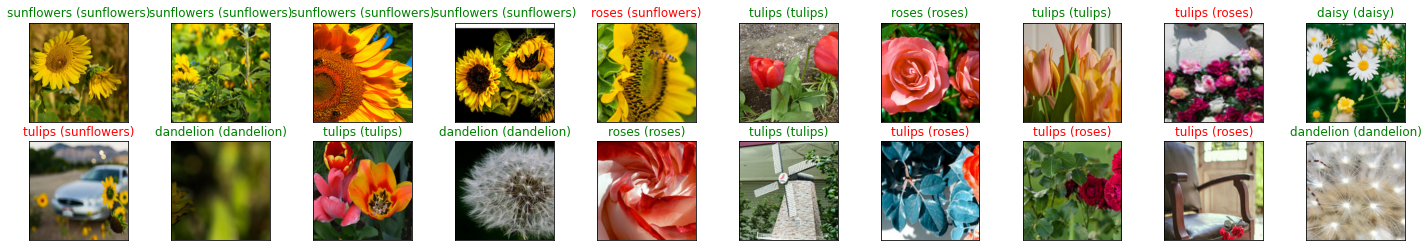

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if device == 'gpu':
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if device != 'gpu' else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))